# Linear Classification

In this lab you will implement parts of a linear classification model using the regularized empirical risk minimization principle. By completing this lab and analysing the code, you gain deeper understanding of these type of models, and of gradient descent.


## Problem Setting

The dataset describes diagnosing of cardiac Single Proton Emission Computed Tomography (SPECT) images. Each of the patients is classified into two categories: normal (1) and abnormal (0). The training data contains 80 SPECT images from which 22 binary features have been extracted. The goal is to predict the label for an unseen test set of 187 tomography images.

In [86]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2

testfile = urllib.request.URLopener()
#testfile.retrieve("http://archive.ics.uci.edu/dataset/95/spect+heart", "SPECT.train")
#testfile.retrieve("http://archive.ics.uci.edu/ml/machine-learning-databases/spect/SPECT.test", "SPECT.test")

df_train = pd.read_csv('SPECT.train',header=None)
df_test = pd.read_csv('SPECT.test',header=None)

train = df_train.values
test = df_test.values

y_train = train[:,0]
X_train = train[:,1:]
y_test = test[:,0]
X_test = test[:,1:]

In [35]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((80, 22), (80,), (187, 22), (187,))

### Exercise 1

Analyze the function learn_reg_ERM(X,y,lambda) which for a given $n\times m$ data matrix $\textbf{X}$ and binary class label $\textbf{y}$ learns and returns a linear model $\textbf{w}$.
The binary class label has to be transformed so that its range is $\left \{-1,1 \right \}$. 
The trade-off parameter between the empirical loss and the regularizer is given by $\lambda > 0$. 
To adapt the learning rate the Barzilai-Borwein method is used.

Try to understand each step of the learning algorithm and comment each line.


In [191]:
def learn_reg_ERM(X,y,lbda,runs):
    # Setting up the hyper parameters
    max_iter = runs
    
    losses = []
    # Setting up the alpha to 1 and the min difference that has to be achieved between old and new params
    e  = 0.001
    alpha = 1.
    
    # The parameters or weights of the features, basically how much a feature contributes in making a prediction
    w = np.random.randn(X.shape[1]);
    
    for k in np.arange(max_iter):
        # Taking dot product of weights and the feature values of the instances -> This is kind of a predicted y values without doing anything.
        h = np.dot(X,w)
        
        #print(f"H = ",h.shape)
        
        # Calculating the loss and the gradient loss between the predictions (generated via the weights and the instance features) & true values
        l,lg = loss(h, y)
        losses.append(np.mean(l))
        
        #print (f'loss on iter {k}: {np.mean(l)}')
        
        # Getting the value from the regularizer and the regularizer gradient given the weights of the features and the lambda
        r,rg = reg(w, lbda)
        
        # This is the whole gradient
        # lg is gradient wrt h, to get final gradient wrt theta we multiply it with X.T
        g = np.dot(X.T,lg) + rg
        
        if (k > 0):
            # Computing the new step size using this formula, and we start this from the 1st iter
            # If you are bouncing a lot i.e. difference in old step and new step is too much, then we decrease the step size more.
            # Think in terms of angle between the old and new gradients
            alpha = alpha * (np.dot(g_old.T,g_old))/(np.dot((g_old - g).T,g_old)) 
        
        # Updating the parameters
        w = w - alpha * g
        
        # Stopping criterion if the norm of gradient is not that big enough, i.e. we don't change the parameters more... so we stop the training.
        if (np.linalg.norm(alpha * g) < e):
            break
        
        # Setting the old gradient to new one.
        g_old = g
    return w,np.array(losses)

### Exercise 2

Fill in the code for the function loss(h,y) which computes the hinge loss and its gradient. 
This function takes a given vector $\textbf{y}$ with the true labels $\in \left \{-1,1\right \}$ and a vector $\textbf{h}$ with the function values of the linear model as inputs. The function returns a vector $\textbf{l}$ with the hinge loss $\max(0, 1 − y_{i} h_{i})$ and a vector $\textbf{g}$ with the gradients of the hinge loss w.r.t $\textbf{h}$. (Note: The partial derivative of the hinge loss with respect to $\textbf{h}$  is $g_{i} = −y $ if $l_{i} > 0$, else $g_{i} = 0$)

In [196]:
def loss(h, y):
    ##################
    #l = np.max(0,1-np.dot(y.T,h))
    l = np.maximum(0, 1-h*y)
    g = np.zeros(h.shape)
    g[np.where(l>0)] = y[np.where(l>0)]*-1
    #print(f"L = {l}")
    # we are calculating the gradient wrt h since that is what consists our parameter theta's
    
    #g = -1*y if l>0 else np.zeros(len(y))
    ##################
    return l, g

### Exercise 3

Fill in the code for the function reg(w,lambda) which computes the $\mathcal{L}_2$-regularizer and the gradient of the regularizer function at point $\textbf{w}$. 


$$r = \frac{\lambda}{2} \textbf{w}^{T}\textbf{w}$$

$$g = \lambda \textbf{w}$$

In [197]:
def reg(w, lbda):
    ##################
    # value of the L2 regularizer that punishes the params more since it's taking into account the sum of squares of their values. The squares come into place by dot(w.T,w)
    r = lbda*np.dot(w.T,w)*0.5
    g = lbda*w
    ##################
    return r, g

### Exercise 4

Fill in the code for the function predict(w,x) which predicts the class label $y$ for a data point $\textbf{x}$ or a matrix $X$ of data points (row-wise) for a previously trained linear model $\textbf{w}$. If there is only a data point given, the function is supposed to return a scalar value. If a matrix is given a vector of predictions is supposed to be returned.

In [201]:
def predict(w, X):
    preds = np.dot(X,w)
    preds = [1 if p>0 else 0 for p in preds]
    return preds

### Exercise 5

#### 5.1 
Train a linear model on the training data and classify all 187 test instances afterwards using the function predict. 
Please note that the given class labels are in the range $\left \{0,1 \right \}$, however the learning algorithm expects a label in the range of $\left \{-1,1 \right \}$. Then, compute the accuracy of your trained linear model on both the training and the test data. 

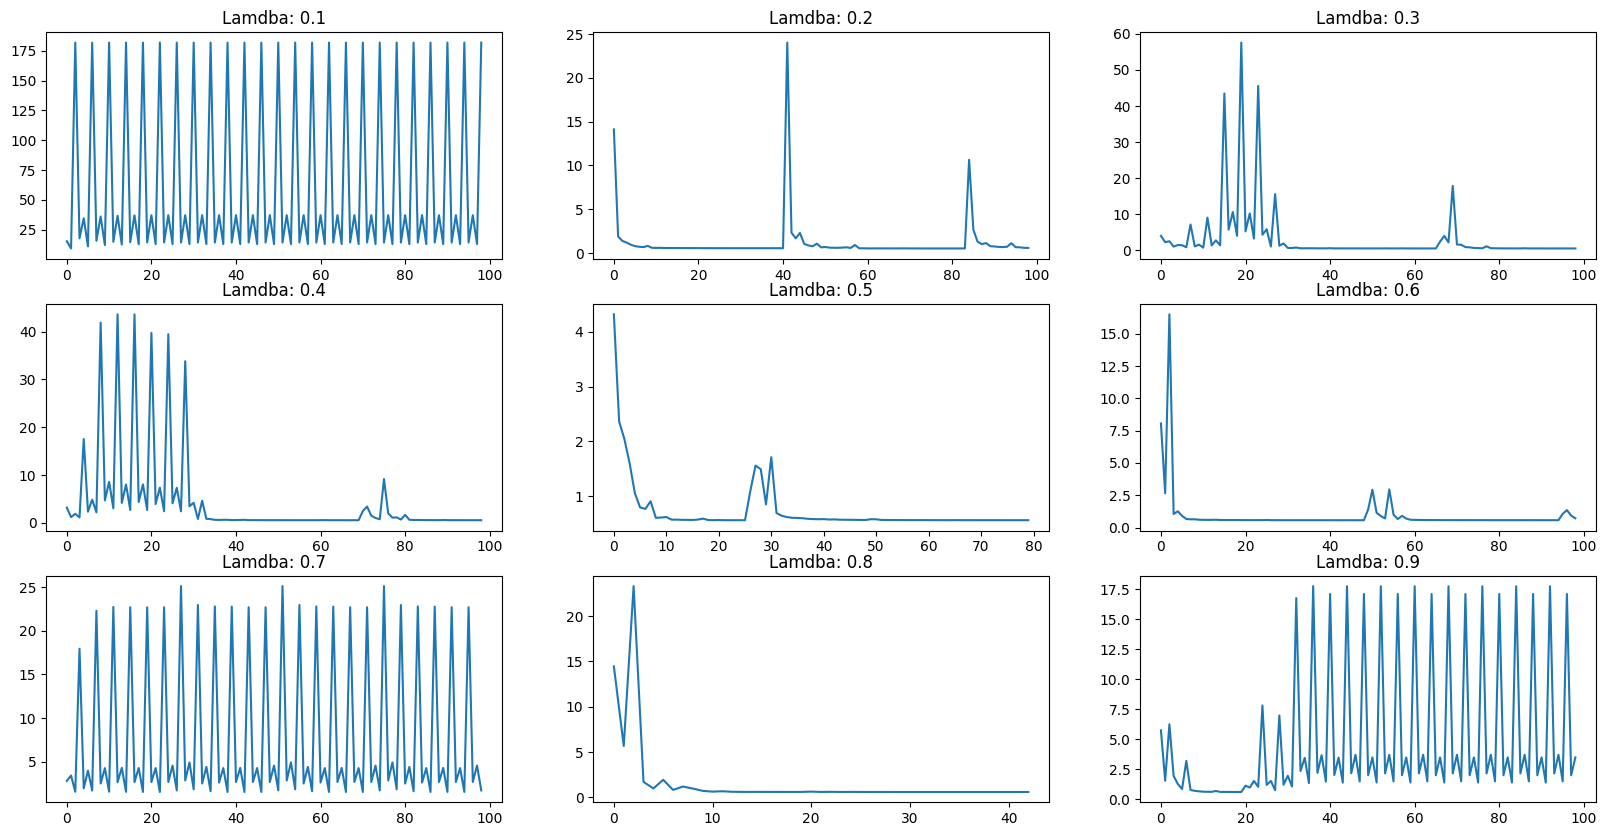

In [211]:
y_train_t = y_train*2 - 1
y_test_t = y_test*2 - 1

lbda = np.arange(0.1, 1, 0.1)


fig, axs = plt.subplots(3,3,figsize = (20,10))
axs = axs.ravel()
for i,l in enumerate(lbda):
    w,losses = learn_reg_ERM(X_train,y_train_t,lbda = l, runs = 100)
    axs[i].plot(losses[1:])
    axs[i].set_title(f"Lamdba: {round(l,2)}")
plt.show()

In [215]:
lbda = np.arange(0.1, 5, 0.1) # Higher lambda means simple function and we have a capability to overfit the val data

for i,l in enumerate(lbda):
    w,losses = learn_reg_ERM(X_train,y_train_t,lbda = l, runs = 100)
    preds = predict(w,X_train)
    print(f"Train Accuracy for lambda {round(l,2)}: {accuracy_score(y_train_t,preds)}")
    
    preds = predict(w,X_test)
    print(f"Test Accuracy for lambda {round(l,2)}: {accuracy_score(y_test_t,preds)}")

Train Accuracy for lambda 0.1: 0.475
Test Accuracy for lambda 0.1: 0.8983957219251337
Train Accuracy for lambda 0.2: 0.0
Test Accuracy for lambda 0.2: 0.0
Train Accuracy for lambda 0.3: 0.0
Test Accuracy for lambda 0.3: 0.0
Train Accuracy for lambda 0.4: 0.475
Test Accuracy for lambda 0.4: 0.8983957219251337
Train Accuracy for lambda 0.5: 0.475
Test Accuracy for lambda 0.5: 0.8983957219251337
Train Accuracy for lambda 0.6: 0.4625
Test Accuracy for lambda 0.6: 0.8663101604278075
Train Accuracy for lambda 0.7: 0.0
Test Accuracy for lambda 0.7: 0.0
Train Accuracy for lambda 0.8: 0.425
Test Accuracy for lambda 0.8: 0.7165775401069518
Train Accuracy for lambda 0.9: 0.425
Test Accuracy for lambda 0.9: 0.6951871657754011
Train Accuracy for lambda 1.0: 0.4375
Test Accuracy for lambda 1.0: 0.732620320855615
Train Accuracy for lambda 1.1: 0.4375
Test Accuracy for lambda 1.1: 0.7379679144385026
Train Accuracy for lambda 1.2: 0.0
Test Accuracy for lambda 1.2: 0.0
Train Accuracy for lambda 1.3: 0.4

#### 5.2
Compare the accuracy of the linear model with the accuracy of a random forest and a decision tree on the training and test data set.

### Random Forest Classifier

In [164]:
from sklearn.ensemble import RandomForestClassifier

In [213]:
rfc = RandomForestClassifier(n_estimators = 1000,max_depth = 10)
rfc.fit(X_train,y_train)
preds = rfc.predict(X_test)
print(f"Accuracy for Random Forests:{accuracy_score(y_test,preds)}")

Accuracy for Random Forests:0.7807486631016043


### Decision Tree Classifier

In [190]:
from sklearn.tree import DecisionTreeClassifier
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=10) # Since we are using the Entropy criterion, so we are working on categorical target data
clf_tree.fit(X_train,y_train)
preds = clf_tree.predict(X_test)
print(f"Accuracy for Random Forests:{accuracy_score(y_test,preds)}")

Accuracy for Random Forests:0.7112299465240641
